# Линейная алгебра: сходство текстов и аппроксимация функций

### Вы научитесь:
  * читать тексты из файла с помощью Python и разбивать их на слова
  * переводить тексты в векторные пространства, вычислять расстояния в этих пространствах
  * решать системы линейных уравнений
  * приближать любые функции с помощью многочленов
  
## Введение

В этом задании вы познакомитесь с некоторыми базовыми методами из линейной алгебры, реализованными в пакете SciPy — в частности, с методами подсчета косинусного расстояния и решения систем линейных уравнений. Так, на решении систем линейных уравнений основана настройка линейных моделей — очень большого и важного класса алгоритмов машинного обучения. Косинусное расстояние же часто используется в анализе текстов для измерения сходства между ними.

## Материалы

Справка по функциям пакета scipy.linalg: http://docs.scipy.org/doc/scipy/reference/linalg.html

Справка по работе с файлами в Python: https://docs.python.org/2/tutorial/inputoutput.html#reading-and-writing-files

Справка по регулярным выражениям в Python (если вы захотите узнать про них чуть больше): https://docs.python.org/2/library/re.html

## Задача 1: сравнение предложений

Дан набор предложений, скопированных с Википедии. Каждое из них имеет "кошачью тему" в одном из трех смыслов:

  * кошки (животные)
  * UNIX-утилита cat для вывода содержимого файлов
  * версии операционной системы OS X, названные в честь семейства кошачьих
Ваша задача — найти два предложения, которые ближе всего по смыслу к расположенному в самой первой строке. В качестве меры близости по смыслу мы будем использовать косинусное расстояние.

#### Выполните следующие шаги:

1. Скачайте файл с предложениями (sentences.txt).
2. Каждая строка в файле соответствует одному предложению. Считайте их, приведите каждую к нижнему регистру с помощью строковой функции lower().
3. Произведите токенизацию, то есть разбиение текстов на слова. Для этого можно воспользоваться регулярным выражением, которое считает разделителем любой символ, не являющийся буквой: re.split('[^a-z]', t). Не забудьте удалить пустые слова после разделения.
4. Составьте список всех слов, встречающихся в предложениях. Сопоставьте каждому слову индекс от нуля до (d - 1), где d — число различных слов в предложениях. Для этого удобно воспользоваться структурой dict.
5. Создайте матрицу размера n x d, где n — число предложений. Заполните ее: элемент с индексом (i, j) в этой матрице должен быть равен количеству вхождений j-го слова в i-е предложение. У вас должна получиться матрица размера 22 * 254.
6. Найдите косинусное расстояние от предложения в самой первой строке (In comparison to dogs, cats have not undergone...) до всех остальных с помощью функции scipy.spatial.distance.cosine. Какие номера у двух предложений, ближайших к нему по этому расстоянию (строки нумеруются с нуля)? Эти два числа и будут ответами на задание.
7. Совпадают ли ближайшие два предложения по тематике с первым? Совпадают ли тематики у следующих по близости предложений?

Разумеется, использованный вами метод крайне простой. Например, он не учитывает формы слов (так, cat и cats он считает разными словами, хотя по сути они означают одно и то же), не удаляет из текстов артикли и прочие ненужные слова.

In [1]:
import pandas as pd
import numpy as np
from scipy import spatial
import re

In [2]:
# ваш код
f = open('sentences.txt', 'r')
lower_lines = [line.locer() for line in f]
f.close()

tokens = [
    [token for token in re.split('[^a-z]', sentence) if token] 
    for sentence in locer_lines]

unique = {
    cord: index for index, cord in enumerate(sorted(set(
        [
            x
            for xs in tokens
            for x in xs
        ]
    )))
}

array = np.asarray ([
    [
        sum([1 for _ in re.finditer(r'\b%s\b' % re.escape(cord), sentence)])
        for word in unique
    ]
    for sentence in lower_lines
])

distances = [spatial.distance.cosine(array[0], array[i]) 
             for i in range(1, len(lower_lines))]

sorted_dist = np.argsort(distances)

closest1 = sorted_dist[:2]
closest2 = sorted_dist[2:4]

print(closest1)
print(closest2)

[5 3]
[20  9]


In [3]:
print(lower_lines[0])

in comparison to dogs, cats have not undergone major changes during the domestication process.



In [4]:
# беру индексы +1
# т.к массив расстояний на 1 меньше чем исходный массив предложений
print(lower_lines[6])
print(lower_lines[4])

domestic cats are similar in size to the other members of the genus felis, typically weighing between 4 and 5 kg (8.8 and 11.0 lb).

in one, people deliberately tamed cats in a process of artificial selection, as they were useful predators of vermin.



In [5]:
print(lower_lines[21])
print(lower_lines[10])

the fifth major update to mac os x, leopard, contains such a mountain of features - more than 300 by apple's count.

cat command is one of the basic commands that you learned when you started in the unix / linux world.



Таким образом тематики первых 2х по близости предложений совпадают с исходным, но тематики 3 и 4 уже отличаются

## Задача 2: аппроксимация функции

Рассмотрим сложную математическую функцию на отрезке [1, 15]:

f(x) = sin(x / 5) * exp(x / 10) + 5 * exp(-x / 2)

Она может описывать, например, зависимость оценок, которые выставляют определенному сорту вина эксперты, в зависимости от возраста этого вина. По сути, задача машинного обучения состоит в том, чтобы приблизить сложную зависимость с помощью функции из определенного семейства. В этом задании мы будем приближать указанную функцию с помощью многочленов.

Как известно, многочлен степени n (то есть w_0 + w_1 x + w_2 x^2 + ... + w_n x^n) однозначно определяется любыми n + 1 различными точками, через которые он проходит. Это значит, что его коэффициенты w_0, ... w_n можно определить из следующей системы линейных уравнений:


где через x_1, ..., x_n, x_{n+1} обозначены точки, через которые проходит многочлен, а через f(x_1), ..., f(x_n), f(x_{n+1}) — значения, которые он должен принимать в этих точках.

Воспользуемся описанным свойством, и будем находить приближение функции многочленом, решая систему линейных уравнений.

1. Сформируйте систему линейных уравнений (то есть задайте матрицу коэффициентов A и свободный вектор b) для многочлена первой степени, который должен совпадать с функцией f в точках 1 и 15. Решите данную систему с помощью функции scipy.linalg.solve. Нарисуйте функцию f и полученный многочлен. Хорошо ли он приближает исходную функцию?
2. Повторите те же шаги для многочлена второй степени, который совпадает с функцией f в точках 1, 8 и 15. Улучшилось ли качество аппроксимации?
3. Повторите те же шаги для многочлена третьей степени, который совпадает с функцией f в точках 1, 4, 10 и 15. Хорошо ли он аппроксимирует функцию?

In [6]:
%matplotlib inline
import math
from matplotlib import pyplot as plt

def f(x):
    return math.sin(x/5.)*math.exp(x/10.) + 5*math.exp(-x/2.)

In [16]:
from scipy import linalg

def poly1(x, c):
  return c[0] + c[1] * x

def poly2(x, c):
  return c[0] + c[1] * x + c[2] * x**2

def poly3(x, c):
  return c[0] + c[1] * x + c[2] * x**2 + c[3] * x**3
    
x = np.arange(1, 16, 0.1)
y = list(map(f, x))

xs1 = [1, 16]
xs2 = [1, 8.5, 16]
xs3 = [1, 6, 11, 16]

f1 = np.array([f(x) for x in xs1])
f2 = np.array([f(x) for x in xs2])
f3 = np.array([f(x) for x in xs3])

A1 = np.array([[1, x] for x in xs1])
A2 = np.array([[1, x, x*x] for x in xs2])
A3 = np.array([[1, x, x*x, x*x*x] for x in xs3])

approxCoeffs1 = linalg.solve(A1, f1)
approxCoeffs2 = linalg.solve(A2, f2)
approxCoeffs3 = linalg.solve(A3, f3)

approx1 = [poly1(xi, approxCoeffs1) for xi in x]
approx2 = [poly2(xi, approxCoeffs2) for xi in x]
approx3 = [poly3(xi, approxCoeffs3) for xi in x]

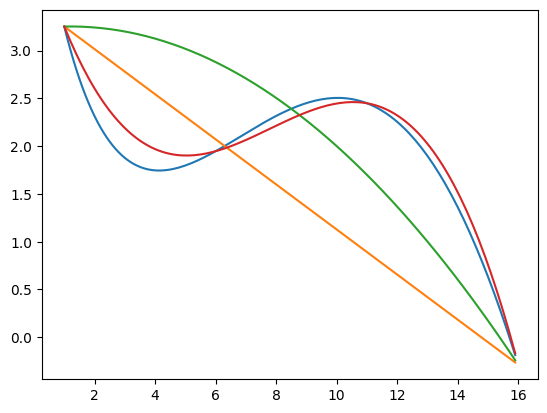

In [17]:
plt.plot(x, y)
plt.plot(x, approx1)
plt.plot(x, approx2)
plt.plot(x, approx3)